In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

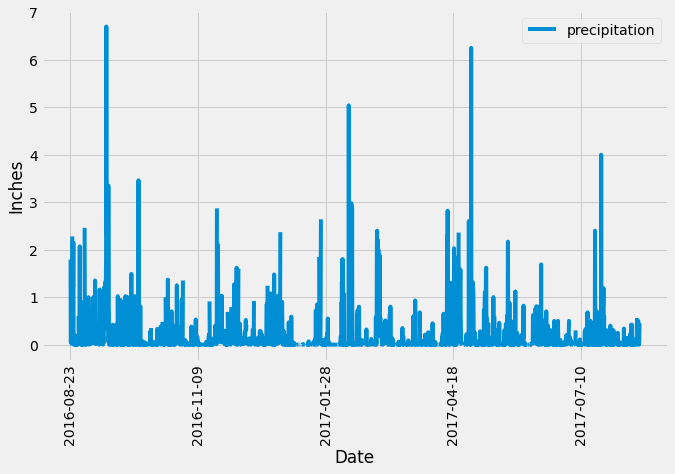

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
prcp_12m = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(prcp_12m.statement, engine, index_col='date')

# Sort the dataframe by date
df_sort = df.sort_index(ascending=True, inplace=False)

# Use Pandas Plotting with Matplotlib to plot the data
df_sort.plot(grid=True, xlabel='Date', ylabel='Inches', figsize=(10,6), rot=90)
plt.legend(['precipitation'])

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_sort.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).distinct().count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, 
                         func.count(Measurement.station)).\
                         order_by(func.count(Measurement.station).desc()).\
                         group_by(Measurement.station).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = stations[0][0]
    
lowest = session.query(func.min(Measurement.tobs)).\
                       filter_by(station = active_station).first()

highest = session.query(func.max(Measurement.tobs)).\
                       filter_by(station = active_station).first()

average = session.query(func.avg(Measurement.tobs)).\
                       filter_by(station = active_station).first()

print(f'The lowest temperature for {active_station} was {lowest[0]}.')
print(f'The highest temperature for {active_station} was {highest[0]}.')
print(f'The average temperature for {active_station} was {average[0]}.')

The lowest temperature for USC00519281 was 54.0.
The highest temperature for USC00519281 was 85.0.
The average temperature for USC00519281 was 71.66378066378067.


Text(0.5, 1.0, '12 Months TOBS for USC00519281')

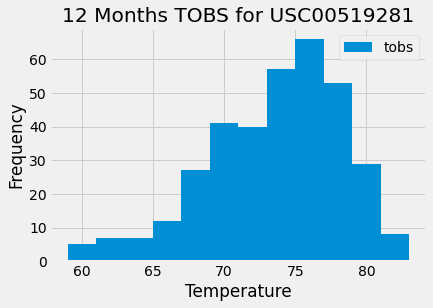

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_12m = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= query_date).\
            filter_by(station = active_station)

df_tobs = pd.read_sql_query(temp_12m.statement, engine, index_col='date')
df_tobs.hist(grid=True, figsize=(6,4), bins=12)
plt.legend(['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'12 Months TOBS for {active_station}')

# Close session

In [16]:
# Close Session
session.close()